/var/folders/8w/bmwl8d950jz75tsw3l1xlnm80000gn/T/ipykernel_29897/374608391.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


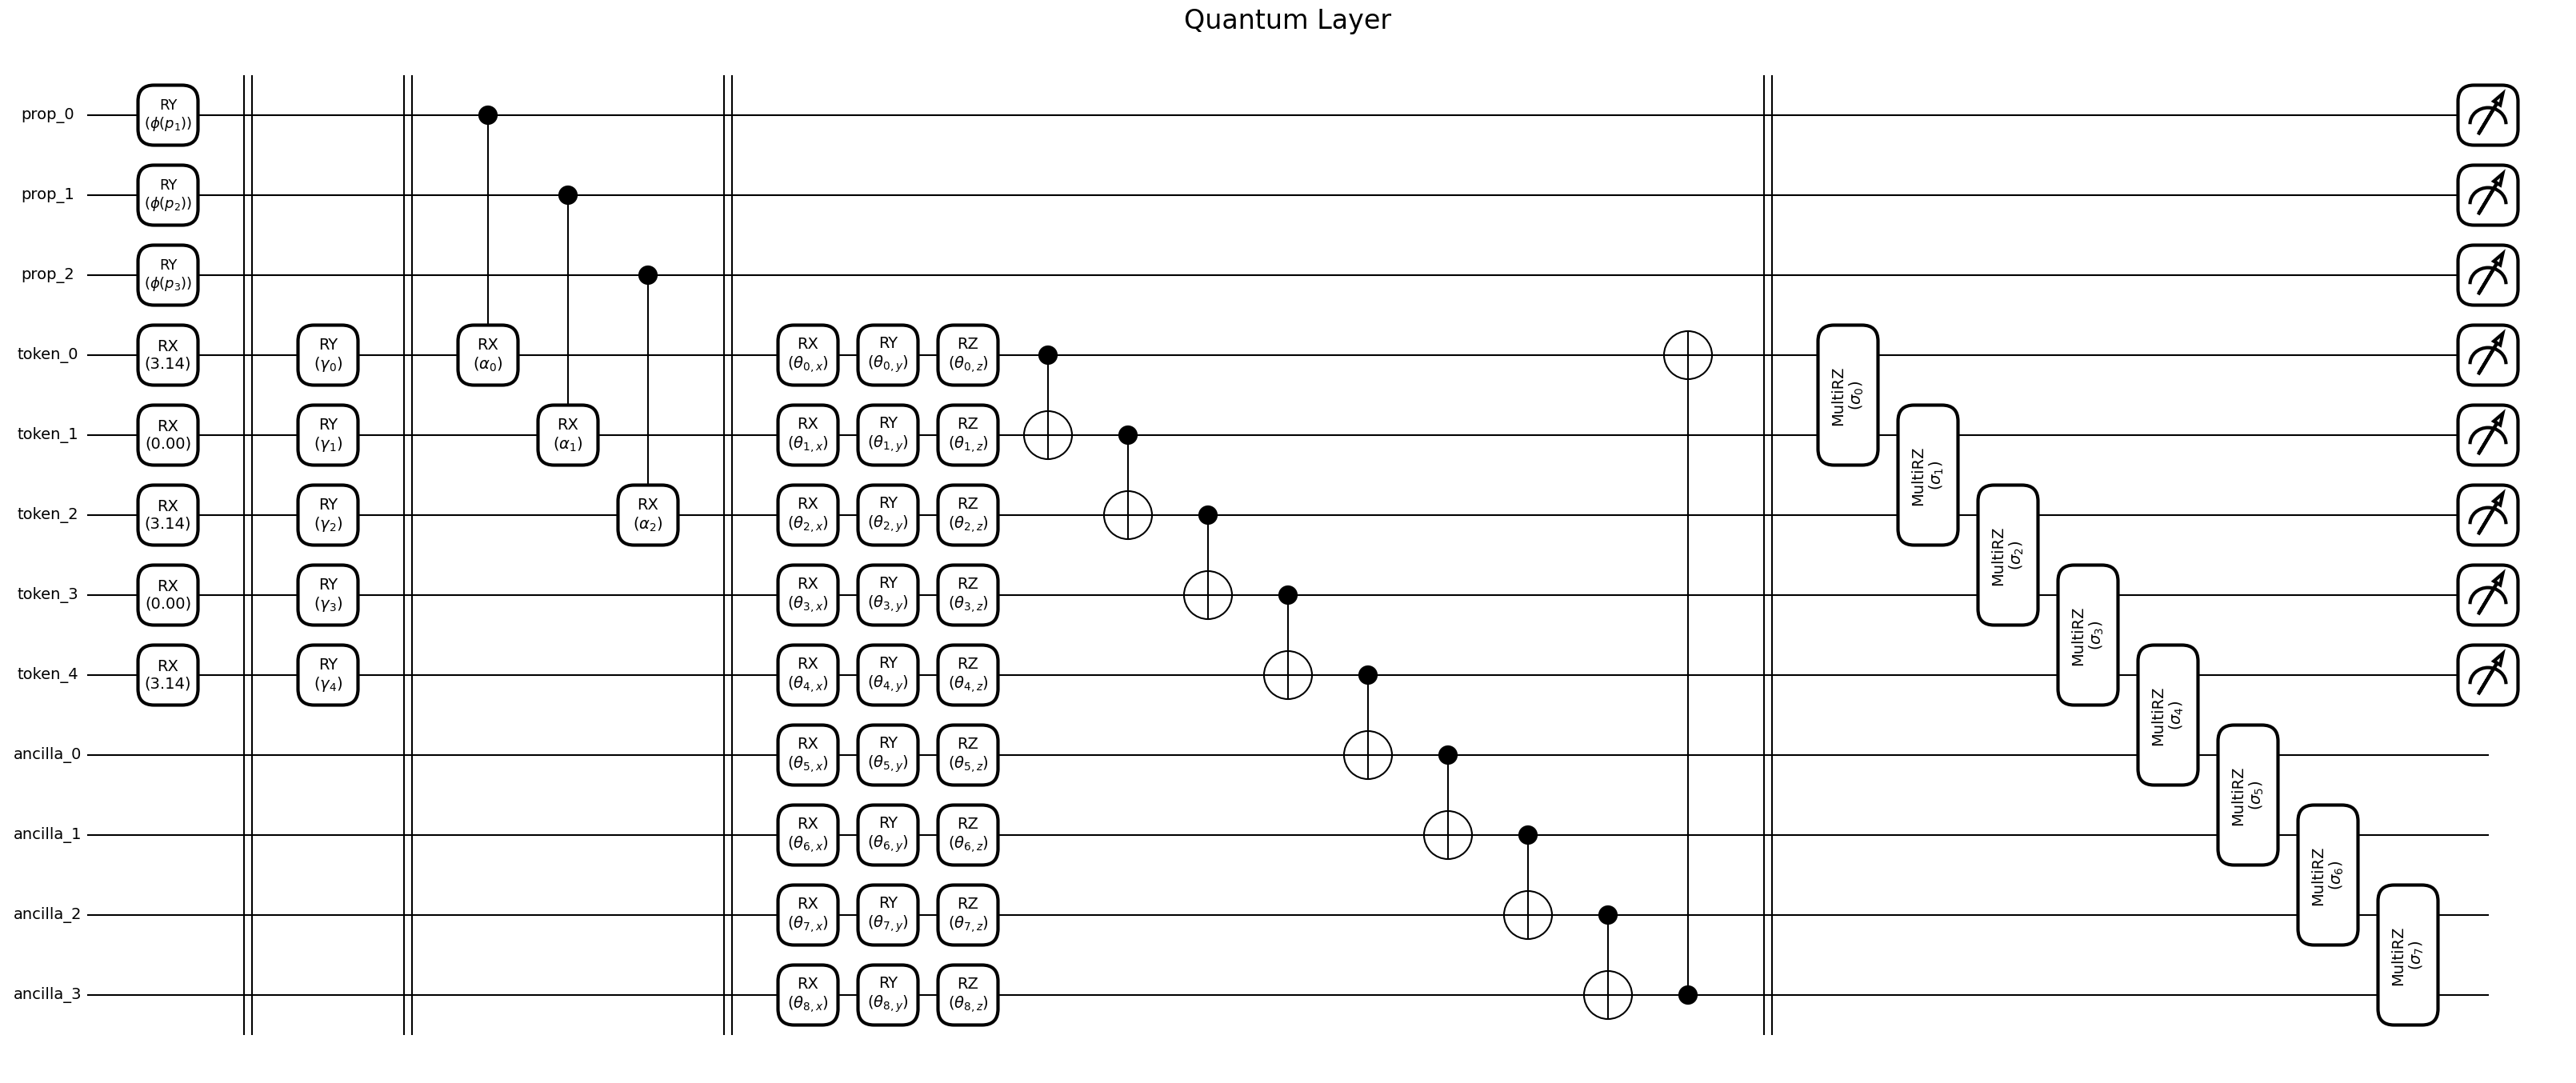

In [9]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
# --- 1. CONFIGURATION & WIRES ---
BITS_PER_TOKEN = 5 
n_prop_qubits = 3
n_ancillas = 4
n_token_ancilla = BITS_PER_TOKEN + n_ancillas

prop_wires = [f"prop_{i}" for i in range(n_prop_qubits)]
token_wires = [f"token_{i}" for i in range(BITS_PER_TOKEN)]
ancilla_wires = [f"ancilla_{i}" for i in range(n_ancillas)]
all_wires = prop_wires + token_wires + ancilla_wires
token_ancilla_ws = token_wires + ancilla_wires 

# Use default device for drawing
dev = qml.device("default.qubit", wires=all_wires)

# --- 2. HELPER FUNCTIONS (MODIFICADAS PARA DIBUJAR) ---

def zstring_combos(wires):
    # Return nearest-neighbor pairs for cleaner drawing
    return [wires[i:i+2] for i in range(len(wires)-1)]

def molecular_property_encoder(props):
    # Eliminamos la multiplicación matemática para permitir texto
    # Asumimos que 'props' ya trae el texto formateado
    for wire, val in zip(prop_wires, props):
        qml.RY(val, wires=wire)

def token_encoder(token_bits):
    # Aquí mantenemos números porque los tokens son discretos (0/1)
    # Si quieres símbolos, cambia esto también.
    for i in range(BITS_PER_TOKEN):
        angle = token_bits[i] * np.pi 
        qml.RX(angle, wires=token_wires[i])

def operator_layer(theta_params, theta_prop, wires):
    n_tokens = len(token_wires)
    token_ancilla_ws = token_wires + ancilla_wires

    # 1. Sparse Property Entanglement
    for i, prop_wire in enumerate(prop_wires):
        target_wire = token_wires[i % n_tokens]
        # theta_prop es ahora una matriz de strings
        qml.CRX(theta_prop[i][0][0], wires=[prop_wire, target_wire])
        
    qml.Barrier(wires=all_wires)
    
    # 2. Backbone Entanglement
    # Apply single-qubit rotations with SYMBOLS
    for i, wire in enumerate(token_ancilla_ws):
        # Accedemos a los strings en theta_params
        qml.RX(theta_params[i][0], wires=wire)
        qml.RY(theta_params[i][1], wires=wire)
        qml.RZ(theta_params[i][2], wires=wire)
    
    # Apply entangling gates
    for i in range(len(token_ancilla_ws)):
        qml.CNOT(wires=[token_ancilla_ws[i], token_ancilla_ws[(i+1) % len(token_ancilla_ws)]])

def Sigma_layer_vec(gamma_vec, token_ancilla_ws, time=1.0):
    combos = zstring_combos(token_ancilla_ws)
    gamma_subset = gamma_vec[:len(combos)]
    for gamma, combo in zip(gamma_subset, combos):
        # Eliminamos la multiplicación -2*gamma*time para que acepte el string "gamma"
        qml.MultiRZ(gamma, wires=list(combo))

# --- 3. THE DRAWING QNODE ---

@qml.qnode(dev)
def draw_one_layer_circuit(token_bits, props, theta_params, theta_prop, sigma_params, attention_context):
    # A. Data Re-injection
    token_encoder(token_bits)
    # Pasamos props directamente (ya son strings)
    molecular_property_encoder(props,) 
    
    qml.Barrier(wires=all_wires)
    
    # B. Attention Context Injection
    for i, val in enumerate(attention_context):
        qml.RY(val, wires=token_wires[i])
        
    qml.Barrier(wires=all_wires)
    
    # C. Entanglement Operator V(theta)
    operator_layer(theta_params, theta_prop, wires=all_wires)
    
    qml.Barrier(wires=all_wires)
    
    # D. Diagonal Hamiltonian Evolution Sigma(gamma)
    Sigma_layer_vec(sigma_params, token_ancilla_ws)
    
    return [qml.expval(qml.PauliZ(w)) for w in prop_wires], qml.probs(wires=token_wires)

# --- 4. DATA GENERATION (CREACIÓN DE ETIQUETAS DE TEXTO) ---

# Tokens reales (números)
dummy_token_bits = np.array([1, 0, 1, 0, 1]) 

# Properties como TEXTO (LaTeX)
# Usamos r"..." para que Python entienda el formato LaTeX
dummy_props = np.array([r"$\phi(p_1)$", r"$\phi(p_2)$", r"$\phi(p_3)$"])

# Atención como TEXTO
dummy_attn = np.array([f"$\\gamma_{{{i}}}$" for i in range(BITS_PER_TOKEN)])

# Theta Params como TEXTO
# Creamos una matriz de strings con formato theta_{qubit, eje}
dummy_theta = []
for i in range(n_token_ancilla):
    row = [f"$\\theta_{{{i},x}}$", f"$\\theta_{{{i},y}}$", f"$\\theta_{{{i},z}}$"]
    dummy_theta.append(row)

# Theta Prop como TEXTO
dummy_theta_prop = []
for i in range(n_prop_qubits):
    # Estructura simplificada para el ejemplo
    dummy_theta_prop.append([[f"$\\alpha_{{{i}}}$"]]) 

# Sigma Params como TEXTO
dummy_sigma = [f"$\\sigma_{{{i}}}$" for i in range(20)]

# --- DRAWING ---

# Ajustamos el estilo para que las cajas sean legibles
fig, ax = qml.draw_mpl(draw_one_layer_circuit, scale=0.6, decimals=2)(
    dummy_token_bits, 
    dummy_props, 
    dummy_theta, 
    dummy_theta_prop, 
    dummy_sigma, 
    dummy_attn
)

plt.title("Quantum Layer", fontsize=24)
plt.tight_layout()
plt.show()

In [24]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import itertools

# --- 1. SETUP & CONFIG ---
BITS_PER_TOKEN = 5
H_LOCAL = 2
n_prop_qubits = 3
n_ancillas = 3

# Define Wires
prop_wires = [f"prop_{i}" for i in range(n_prop_qubits)]
token_wires = [f"token_{i}" for i in range(BITS_PER_TOKEN)]
ancilla_wires = [f"ancilla_{i}" for i in range(n_ancillas)]
all_wires = prop_wires + token_wires + ancilla_wires
token_ancilla_ws = token_wires + ancilla_wires

dev = qml.device("default.qubit", wires=all_wires)

# --- 2. ROBUST FUNCTIONS (Fixed to handle Strings for Drawing) ---

def zstring_combos(wires):
    """Generate combinations for Sigma layer"""
    L = []
    for k in range(1, H_LOCAL + 1):
        L.extend(itertools.combinations(wires, k))
    return [tuple(c) for c in L]

def molecular_property_encoder(props, prop_scaling=None):
    """Safe encoder that checks for string inputs before multiplying"""
    # If props are strings (drawing mode) or scaling is None, skip math
    if prop_scaling is None or (len(props) > 0 and isinstance(props[0], str)):
        scaled_props = props
    else:
        scaled_props = props * prop_scaling

    for wire, val in zip(prop_wires, scaled_props):
        qml.RY(val, wires=wire)

def token_encoder(token_bits):
    """Safe token encoder"""
    for i in range(BITS_PER_TOKEN):
        val = token_bits[i]
        # If val is a string (drawing mode), use it directly as the angle label
        angle = val if isinstance(val, str) else val * np.pi 
        qml.RX(angle, wires=token_wires[i])

def Sigma_layer_vec(gamma_vec, time=1.0, combos=None):
    """Safe Sigma layer"""
    if combos is None:
        combos = zstring_combos(token_ancilla_ws)
        
    for i, pair in enumerate(combos):
        if i < len(gamma_vec):
            val = gamma_vec[i]
            # If val is a string, use it directly. Otherwise do the physics math.
            angle = val if isinstance(val, str) else -2.0 * val * time
            qml.MultiRZ(angle, wires=list(pair))

def operator_layer(theta_params, theta_prop):
    """Standard Variational Layer"""
    # Property -> Token Entanglement
    for p, prop_wire in enumerate(prop_wires):
        for t, t_a_wire in enumerate(token_ancilla_ws):
            qml.CRX(theta_prop[p, t, 0], wires=[prop_wire, t_a_wire])
            qml.CRY(theta_prop[p, t, 1], wires=[prop_wire, t_a_wire])

    # Strongly Entangling Layers
    # Note: We add a dimension [None,:,:] to match PennyLane template expectations if needed
    # But for drawing with dummy strings, passing the array directly usually works.
    qml.StronglyEntanglingLayers(weights=theta_params, wires=token_ancilla_ws)

# --- 3. DRAWING CIRCUIT DEFINITION ---

@qml.qnode(dev)
def draw_one_layer_circuit(token_bits, props, theta_params, theta_prop, sigma_params, attn_context):
    """A wrapper to draw exactly one layer of the architecture"""
    
    # 1. Encoders
    molecular_property_encoder(props, prop_scaling=None)
    token_encoder(token_bits)
    
    # 2. Attention Injection
    for i, val in enumerate(attn_context):
        qml.RY(val, wires=token_wires[i])
        
    # 3. Variational Block (Showing Layer 0 only)
    # We assume inputs are for a single layer
    operator_layer(theta_params, theta_prop)
    Sigma_layer_vec(sigma_params)
    
    return qml.probs(wires=token_wires)

# --- 4. EXECUTE DRAWING ---

# Create Dummy Data (Strings)
d_token = [f"t_{i}" for i in range(BITS_PER_TOKEN)]
d_props = ["LogP", "QED", "MW"]
d_attn  = [f"ctx_{i}" for i in range(BITS_PER_TOKEN)]

# Create Dummy Weights with correct shapes for 1 layer
n_w = len(token_ancilla_ws)
n_combos = len(zstring_combos(token_ancilla_ws))

# 1. Theta (Strongly Entangling)
d_theta = np.array([[[f"th_{{{w},{k}}}" for k in range(3)] for w in range(n_w)]])

# 2. Theta Prop (Conditioning)
d_theta_prop = np.array([[[f"tp_{{{p},{w},{k}}}" for k in range(2)] 
                          for w in range(n_w)] 
                         for p in range(n_prop_qubits)])

# 3. Sigma (Diagonal Phase)
d_sigma = np.array([f"sig_{{{i}}}" for i in range(n_combos)])

# Draw
# We use a larger figure size to accommodate the labels
fig, ax = qml.draw_mpl(draw_one_layer_circuit, scale=0.6, decimals=2)(
    d_token, d_props, d_theta, d_theta_prop, d_sigma, d_attn
)

plt.title("Conditional Quantum Autoregressive Circuit (1 Layer)", fontsize=16)
plt.tight_layout()
plt.show()

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('float64'), dtype('<U7')) -> None

Generating Quantum Circuit Diagram...


/var/folders/8w/bmwl8d950jz75tsw3l1xlnm80000gn/T/ipykernel_29897/3915677850.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


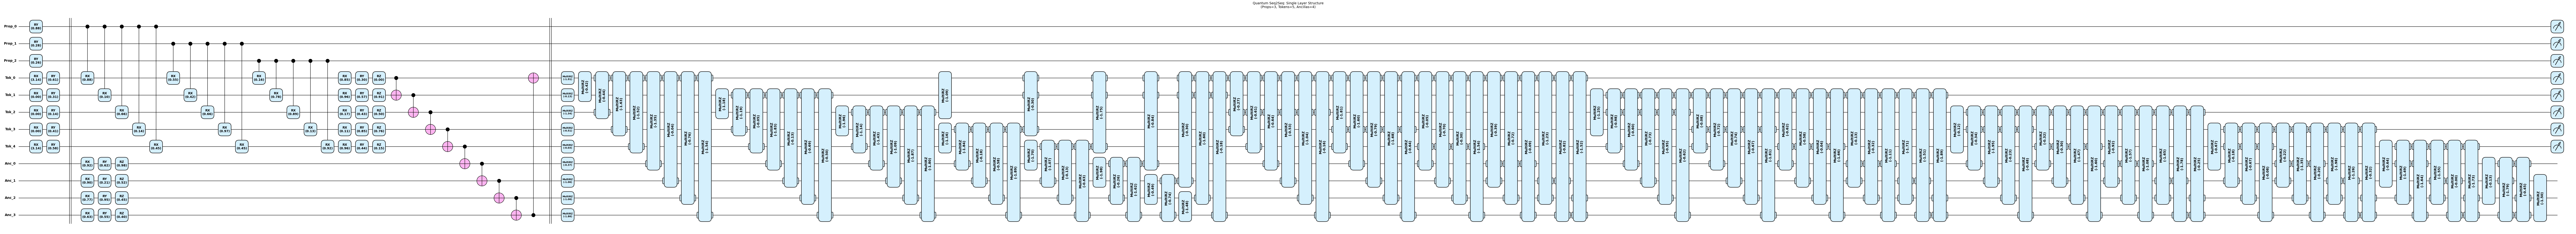

In [33]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import itertools

# --- 1. CONFIGURATION & MOCK DATA ---
# Assuming 5 bits per token (standard for SELFIES)
BITS_PER_TOKEN = 5 
n_prop_qubits = 3
n_ancillas = 4

# Wire definitions
prop_wires = [f"Prop_{i}" for i in range(n_prop_qubits)]
token_wires = [f"Tok_{i}" for i in range(BITS_PER_TOKEN)]
ancilla_wires = [f"Anc_{i}" for i in range(n_ancillas)]
all_wires = prop_wires + token_wires + ancilla_wires

# Device for visualization
dev = qml.device("default.qubit", wires=all_wires)

# --- 2. HELPER FUNCTIONS (Adapted from your logic) ---

def zstring_combos(wires):
    """Generates combinations for the Sigma layer (mocking your logic)"""
    # Assuming H_LOCAL = 2 or 3 for the diagram
    H_LOCAL = 2
    combos = []
    for k in range(1, H_LOCAL + 1):
        for c in itertools.combinations(wires, k):
            combos.append(list(c))
    return combos

def molecular_property_encoder(props, prop_scaling):
    """RY rotations for properties"""
    # We use qml.math to be backend agnostic
    scaled_props = props * prop_scaling
    for wire, val in zip(prop_wires, scaled_props):
        qml.RY(val, wires=wire)

def token_encoder(token_bits):
    """Basis encoding for tokens"""
    for i in range(BITS_PER_TOKEN):
        angle = token_bits[i] * np.pi 
        qml.RX(angle, wires=token_wires[i])

def dense_operator_layer(theta_params, theta_prop):
    # Part A: Cross Entanglement (Props -> Tokens)
    param_idx = 0
    for prop_w in prop_wires:
        for token_w in token_wires:
            qml.CRX(theta_prop[param_idx], wires=[prop_w, token_w])
            param_idx += 1
            
    # Part B: Internal Entanglement (Token + Ancilla Backbone)
    # Single Qubit Rotations
    combined_wires = token_wires + ancilla_wires
    for i, wire in enumerate(combined_wires):
        qml.RX(theta_params[i, 0], wires=wire)
        qml.RY(theta_params[i, 1], wires=wire)
        qml.RZ(theta_params[i, 2], wires=wire)
    
    # Ring of CNOTs
    for i in range(len(combined_wires)):
        # Wire i acts as control, (i+1)%N acts as target
        w_c = combined_wires[i]
        w_t = combined_wires[(i+1) % len(combined_wires)]
        qml.CNOT(wires=[w_c, w_t])

def Sigma_layer_vec(gamma_vec, token_ancilla_ws, time=1.0):
    """
    Diagonal multi-Z unitary Σ = exp(i * sum_s gamma_s * Z^{⊗|s|} * t)
    using a flat parameter vector 'gamma_vec' aligned with 'combos'.
    """
    combos = zstring_combos(token_ancilla_ws)

    # Safety: ensure the vector length matches the number of combos
    assert gamma_vec.shape[0] == len(combos), \
        f"gamma_vec has length {gamma_vec.shape[0]} but expected {len(combos)}"

    # MultiRZ(phi) = exp(-i * phi/2 * Z^{⊗k}); choose phi = -2 * gamma * time
    for gamma, combo in zip(gamma_vec, combos):
        qml.MultiRZ(-2.0 * gamma * time, wires=list(combo))

# --- 3. THE CIRCUIT DRAWING QNODE ---

@qml.qnode(dev)
def draw_one_layer_circuit(token_bits, props, context, 
                           prop_scaling, theta_params, theta_prop, sigma_params):
    
    # 1. Encoding Step (Re-injection)
    # To make the diagram cleaner, we group these visually
    token_encoder(token_bits)
    molecular_property_encoder(props, prop_scaling)
    token_ancilla_ws = token_wires + ancilla_wires
    # Context injection
    for i, val in enumerate(context):
        qml.RY(val, wires=token_wires[i])

    qml.Barrier(wires=all_wires, only_visual=True)

    # 2. Dense Operator Layer (V)
    dense_operator_layer(theta_params, theta_prop)
    
    qml.Barrier(wires=all_wires, only_visual=True)

    # 3. Global Sigma Layer (Evolution)
    Sigma_layer_vec(sigma_params, token_ancilla_ws)

    return qml.probs(wires=token_wires), [qml.expval(qml.PauliZ(w)) for w in prop_wires]

# --- 4. EXECUTION & PLOTTING ---

# Create Dummy Data
dummy_token = np.random.randint(0, 2, BITS_PER_TOKEN)
dummy_props = np.random.rand(n_prop_qubits)
dummy_context = np.random.rand(BITS_PER_TOKEN)
dummy_scaling = np.ones(n_prop_qubits)

# Calculate parameter shapes
n_tok_anc = BITS_PER_TOKEN + n_ancillas
n_cross_interactions = n_prop_qubits * BITS_PER_TOKEN
# Mock large enough gamma vector for sigma layer
n_sigma = 129

dummy_theta = np.random.rand(n_tok_anc, 3)
dummy_theta_prop = np.random.rand(n_cross_interactions)
dummy_sigma = np.random.rand(n_sigma)

# Draw
print("Generating Quantum Circuit Diagram...")
fig, ax = qml.draw_mpl(draw_one_layer_circuit, decimals=2, style="pennylane")(
    dummy_token, dummy_props, dummy_context, 
    dummy_scaling, dummy_theta, dummy_theta_prop, dummy_sigma
)

# Formatting
plt.title(f"Quantum Seq2Seq: Single Layer Structure\n(Props={n_prop_qubits}, Tokens={BITS_PER_TOKEN}, Ancillas={n_ancillas})", fontsize=14)
plt.tight_layout()
plt.show()